In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pickle
import sys
from utils import utils
import numpy as np

Name: 
Type: DiGraph
Number of nodes: 78
Number of edges: 80
Average in degree:   1.0256
Average out degree:   1.0256


C:\Users\Pauliina\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Pauliina\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


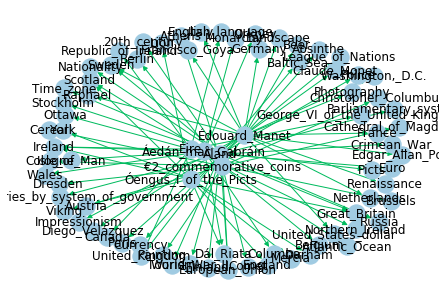

In [2]:
#g = nx.read_edgelist("data/decoded.tsv")

#print(nx.info(g))
pd.read_csv('data/decoded.tsv', nrows=80, delimiter='\t').to_csv('data/decodedSample.tsv', sep='\t', header = False, index = False)

#reading the edgelist in a variable using networkX
subgraph = nx.read_edgelist('data/decodedSample.tsv', delimiter='\t', create_using=nx.DiGraph())
#plotting the graph
print(nx.info(subgraph))
pos=nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color = '#A0CBE2', edge_color = '#00bb5e', width = 1, edge_cmap = plt.cm.Blues, with_labels = True)
plt.savefig("graph_sample.pdf")

In [3]:
def generate_missing_edges(out_file, train_percent = 0.7):
    test_percent = 1 - train_percent
    r = pd.read_csv('data/decoded.tsv', delimiter = '\t', header = None)
    nrows = r.shape[0]
    removable_edges = random.sample(range(nrows), int(nrows*test_percent))    
    temp = r
    temp = temp.drop(removable_edges)
    csv = temp.to_csv('data/smaller_edgelist.tsv', sep='\t', index=False, index_label=False)
    pickle.dump(removable_edges,open(out_file, 'wb'))


In [ ]:
generate_missing_edges('data/removedEdgesList.pkl')

In [4]:
def random_forest_clf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    # print(clf.fit(X_train, y_train).summary())
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return [clf,acc,"Random Forest Classifier"]

def knn_clf(X, y, neighs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    clf = KNeighborsClassifier(n_neighbors = neighs)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return [clf,acc,"K-Nearest Neighbors"]

In [5]:
X = []
with open('data/X_data.pkl', 'rb') as f:
    X = pickle.load(f)
y = []
with open('data/Y_data.pkl', 'rb') as f:
    y = pickle.load(f)

In [6]:
classifiers = []

classifiers.append(random_forest_clf(X,y))

C:\Users\Pauliina\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
classifiers[0][1]

In [7]:
rm_edges = []
with open('data/removedEdgesList.pkl', 'rb') as f:
    rm_edges = pickle.load(f)

# Load original network
G = nx.read_edgelist('data/decoded.tsv', delimiter = '\t', create_using=nx.DiGraph())

# Load smaller network
S = nx.read_edgelist('data/smaller_edgelist.tsv', delimiter = '\t', create_using=nx.DiGraph())

utils.HITS(S, 'data/smaller_hits.pkl')
utils.PR_file(S, 'data/smaller_pr.pkl')

pr = []
with open('data/smaller_pr.pkl', 'rb') as f:
    pr = pickle.load(f)

hits = []
with open('data/smaller_hits.pkl', 'rb') as f:
    hits = pickle.load(f)

cat_dict = []
with open('data/getCategoryFromLinkDict.pkl', 'rb') as f:
    cat_dict = pickle.load(f)

In [8]:
vecs = []
for e in G.edges():
    u, v = e
    a = list(utils.create_X(S,u,v, cat_dict,pr,hits))
    vec = np.array(a)
    vecs.append(vec)

y_preds = classifiers[0][0].predict(vecs)
score = accuracy_score(np.ones(len(G.edges)), y_preds)
print(score)

0.9134565656228625


In [16]:
# Calculate feature importances

feature_importances = list(classifiers[0][0].feature_importances_)
feature_list = list(["no_comm", "jd", "aa", "pr_x", "pr_y", "hits_x", "hits_y"])
f_importances = [(feature, round(feature_importance, 2)) for feature, feature_importance in zip(feature_list, feature_importances)]
# Sort the feature importances by most important first
f_importances = sorted(f_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in f_importances];


Variable: hits_y               Importance: 0.26
Variable: pr_y                 Importance: 0.22
Variable: jd                   Importance: 0.21
Variable: aa                   Importance: 0.18
Variable: hits_x               Importance: 0.07
Variable: pr_x                 Importance: 0.04
Variable: no_comm              Importance: 0.03
